In [64]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sqlalchemy import create_engine, MetaData
from concurrent.futures import ThreadPoolExecutor, as_completed
pd.set_option('display.max_rows', 20)
pd.options.mode.copy_on_write = True

In [65]:
def readLocalDb():
    engine = create_engine('sqlite:///crashes.db')
    df = pd.read_sql_table('crashes', con=engine)
    # filter out timestamps that are problematic
    allCases = df[df['CrashDate'].str.count('-') == 1]
    allCases.loc[:,'CrashDate'] = allCases['CrashDate'].apply(lambda x: datetime.fromtimestamp(int(x[6:19])/1000))
    allCases['CrashDate'] = pd.to_datetime(allCases['CrashDate'], errors='coerce')
    allCases.loc[:, 'CrashDate'] = allCases['CrashDate'].dt.normalize()
    engine.dispose()
    return allCases

def readLocalEnriched():
    engine = create_engine('sqlite:///caseDetails.db')
    df = pd.read_sql_table('details', con=engine)
    # filter out dates that are problematic
    allCases = df[df['CrashDate'].str.count('-') == 1]
    allCases['CrashDate'] = pd.to_datetime(allCases['CrashDate'], errors='coerce')
    allCases.loc[:, 'CrashDate'] = allCases['CrashDate'].dt.normalize()
    engine.dispose()
    return df

# Read vehicle and accident data from CSV files and organize it into DataFrames   
def readVehicles():
    vehicles18 = pd.read_csv("2018/vehicle.csv", encoding='ISO-8859-1')
    vehicles19 = pd.read_csv("2019/vehicle.csv", encoding='ISO-8859-1')
    vehicles20 = pd.read_csv("2020/vehicle.csv", encoding='ISO-8859-1')
    vehicles21 = pd.read_csv("2021/vehicle.csv", encoding='ISO-8859-1')

    vehicles18.loc[:, 'YEAR'] = "2018"
    vehicles19.loc[:, 'YEAR'] = "2019"
    vehicles20.loc[:, 'YEAR'] = "2020"
    vehicles21.loc[:, 'YEAR'] = "2021"
    res = pd.concat([vehicles18, vehicles19, vehicles20, vehicles21], axis=0, ignore_index=False)
    res['ST_CASE'] = res['ST_CASE'].astype(str)
    res['STATENAME'] = res['STATENAME'].astype(str)
    return res

def readDetails():
    accident18 = pd.read_csv("2018/accident.csv", encoding='ISO-8859-1')
    accident19 = pd.read_csv("2019/accident.csv", encoding='ISO-8859-1')
    accident20 = pd.read_csv("2020/accident.csv", encoding='ISO-8859-1')
    accident21 = pd.read_csv("2021/accident.csv", encoding='ISO-8859-1')

    res = pd.concat([accident18, accident19, accident20, accident21], axis=0, ignore_index=False)
    res['YEAR'] = res['YEAR'].astype(str)
    res['ST_CASE'] = res['ST_CASE'].astype(str)
    res['STATENAME'] = res['STATENAME'].astype(str)
    return res

details = readDetails()
vehicles = readVehicles()
allCases = readLocalDb()



C:\Users\menli\AppData\Local\Temp\ipykernel_4768\1000838044.py:40: DtypeWarning: Columns (40,42) have mixed types. Specify dtype option on import or set low_memory=False.
  accident19 = pd.read_csv("2019/accident.csv", encoding='ISO-8859-1')
C:\Users\menli\AppData\Local\Temp\ipykernel_4768\1000838044.py:24: DtypeWarning: Columns (14,56,58,193,195) have mixed types. Specify dtype option on import or set low_memory=False.
  vehicles18 = pd.read_csv("2018/vehicle.csv", encoding='ISO-8859-1')
C:\Users\menli\AppData\Local\Temp\ipykernel_4768\1000838044.py:25: DtypeWarning: Columns (56,58,101,193,195) have mixed types. Specify dtype option on import or set low_memory=False.
  vehicles19 = pd.read_csv("2019/vehicle.csv", encoding='ISO-8859-1')
C:\Users\menli\AppData\Local\Temp\ipykernel_4768\1000838044.py:26: DtypeWarning: Columns (56,58,176,178) have mixed types. Specify dtype option on import or set low_memory=False.
  vehicles20 = pd.read_csv("2020/vehicle.csv", encoding='ISO-8859-1')
C:\U

In [66]:
def findVehiclesBy(case):
    c = str(case['St_Case'])
    st = str(case['StateName'])
    year = str(case['CrashDate'].year)
    return vehicles[(vehicles['ST_CASE'] == c) & (vehicles['STATENAME'] == st) & (vehicles['YEAR'] == year)].iloc[0]

def findDetailBy(case):
    year = str(case['CrashDate'].year)
    c = str(case['St_Case'])
    return details[(details['YEAR'] == year) & (details['ST_CASE'] == c)].iloc[0]
    

def getVehiclesMakeList(detail):
    raw = [item['MAKENAME'] for item in detail['Vehicles']]
    return raw

def seat_position(detail):
    seat_position =[item['SEAT_POSNAME'] for item in detail['Person']]
    return seat_position

def cleanDb(engine):
    metadata = MetaData()
    metadata.reflect(bind=engine)
    metadata.drop_all(engine)
    
def persistDetails(df):
    engine = create_engine('sqlite:///caseDetails.db')
    cleanDb(engine)
    df.to_sql('details', con=engine, index=True)
    engine.dispose()


def enrichCases(cases):
    enriched = cases
    print(cases)
    for idx, row in enriched.iterrows():
        if idx % 100 == 0:
            print(idx)
        try:
            vehicles = findVehiclesBy(row)
            details = findDetailBy(row)
            enriched.at[idx, 'CarMakeList'] = str(vehicles['MAKENAME'])
            enriched.at[idx, 'isDUI'] = details['DRUNK_DR'] == '1'
            enriched.at[idx, 'WEATHER'] = details['WEATHER']
            enriched.at[idx, 'FATALS'] = details['FATALS'] 

        except Exception as e:
            print("error")
    
    return enriched

df = readLocalEnriched() 

In [57]:
df = df.drop(['level_0','index'],axis=1)
df

,Unnamed: 0,CountyName,CrashDate,Fatals,Peds,Persons,St_Case,State,StateName,TotalVehicles,CarMakeList,isDUI,WEATHER,FATAL_COUNT
0,0,COFFEE (31),2017-04-02,1,0,1,10206,1,Alabama,1,Ford,True,1.0,1.0
1,1,LEE (81),2017-04-05,1,0,2,10207,1,Alabama,1,Hyundai,True,10.0,1.0
2,2,PIKE (109),2017-04-07,1,1,1,10208,1,Alabama,1,Hyundai,True,1.0,1.0
3,3,LOWNDES (85),2017-04-10,1,0,1,10209,1,Alabama,1,Ford,True,1.0,1.0
4,4,DALE (45),2017-04-07,2,0,8,10210,1,Alabama,4,Jeep / Kaiser-Jeep / Willys- Jeep,True,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165960,167218,SALT LAKE (35),2021-09-04,1,0,3,490307,49,Utah,1,KIA,True,1.0,1.0
165961,167219,SALT LAKE (35),2021-11-06,1,0,2,490308,49,Utah,1,Subaru,True,10.0,1.0
165962,167220,WASHINGTON (53),2021-12-17,1,0,5,490309,49,Utah,2,KIA,False,1.0,1.0
165963,167221,UTAH (49),2021-09-14,1,0,5,490310,49,Utah,4,Toyota,True,1.0,1.0


In [58]:
# Exclude year 2017 from DataFrame
df['CrashDate'] = pd.to_datetime(df['CrashDate'])
df = df[df['CrashDate'].dt.year>=2018]
df

,Unnamed: 0,CountyName,CrashDate,Fatals,Peds,Persons,St_Case,State,StateName,TotalVehicles,CarMakeList,isDUI,WEATHER,FATAL_COUNT
860,864,TALLADEGA (121),2018-01-05,1,0,1,10001,1,Alabama,2,Freightliner,True,1.0,1.0
861,865,WALKER (127),2018-01-07,2,0,2,10002,1,Alabama,1,Infiniti,True,2.0,2.0
862,866,CHILTON (21),2018-01-08,1,0,2,10003,1,Alabama,2,KIA,False,10.0,1.0
863,867,BALDWIN (3),2018-01-09,1,0,2,10004,1,Alabama,1,Toyota,False,10.0,1.0
864,868,JEFFERSON (73),2018-01-19,1,0,2,10005,1,Alabama,2,Kenworth,True,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165960,167218,SALT LAKE (35),2021-09-04,1,0,3,490307,49,Utah,1,KIA,True,1.0,1.0
165961,167219,SALT LAKE (35),2021-11-06,1,0,2,490308,49,Utah,1,Subaru,True,10.0,1.0
165962,167220,WASHINGTON (53),2021-12-17,1,0,5,490309,49,Utah,2,KIA,False,1.0,1.0
165963,167221,UTAH (49),2021-09-14,1,0,5,490310,49,Utah,4,Toyota,True,1.0,1.0


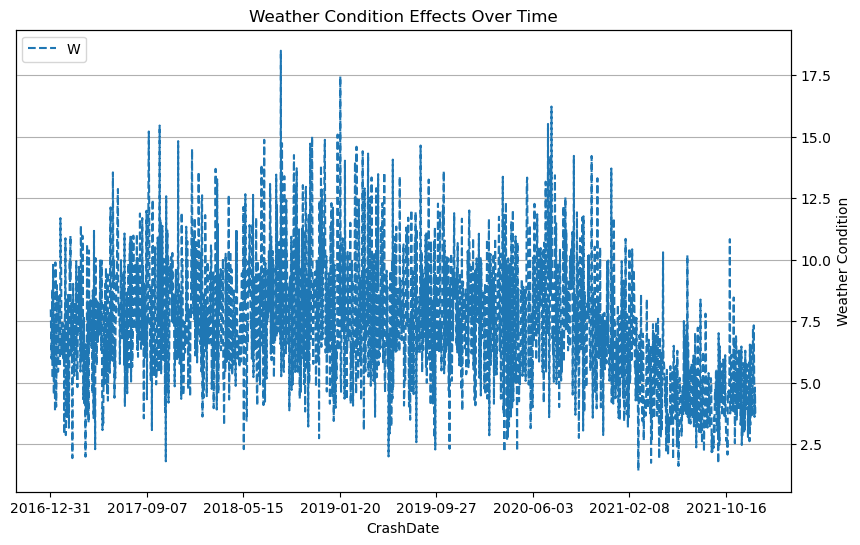

In [67]:
def drawPlot(df):
    avg_weather_per_day = df.groupby('CrashDate')['WEATHER'].mean()
    plt.figure(figsize=(10, 6))
    ax = avg_weather_per_day.plot(kind='line', linestyle='--', label='Average Weather Condition', secondary_y=True)
    ax.legend("Weather, higher being worse", loc='upper left')
    plt.title('Weather Condition Effects Over Time')
    plt.xlabel('Fatal Crashes')
    plt.ylabel('Weather Condition')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

drawPlot(df)

    

Index(['level_0', 'index', 'Unnamed: 0', 'CountyName', 'CrashDate', 'Fatals',
       'Peds', 'Persons', 'St_Case', 'State', 'StateName', 'TotalVehicles',
       'CarMakeList', 'isDUI', 'WEATHER', 'FATAL_COUNT'],
      dtype='object')


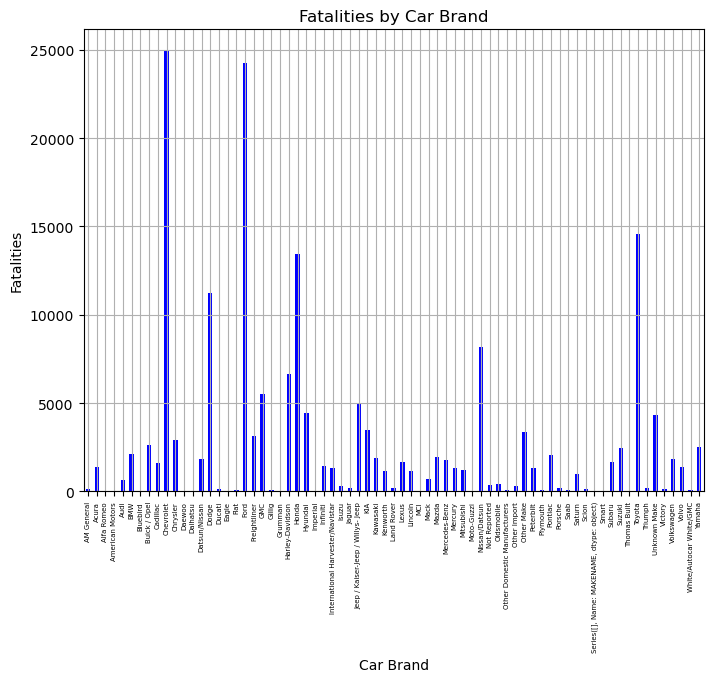

In [60]:
def drawPlot(df):
    fatalities_by_brand= df.groupby('CarMakeList')['Fatals'].sum()
    plt.figure(figsize=(8, 6))
    fatalities_by_brand.plot(kind='bar', color='blue')
    plt.title('Fatalities by Car Brand')
    plt.xlabel('Car Brand')
    plt.ylabel('Fatalities')
    plt.xticks(rotation=90,fontsize=5)
    plt.grid(True)
    plt.show()

df = readLocalEnriched()
df = df.reset_index(drop = True)
print(df.columns)
drawPlot(df)


Index(['level_0', 'index', 'Unnamed: 0', 'CountyName', 'CrashDate', 'Fatals',
       'Peds', 'Persons', 'St_Case', 'State', 'StateName', 'TotalVehicles',
       'CarMakeList', 'isDUI', 'WEATHER', 'FATAL_COUNT'],
      dtype='object')


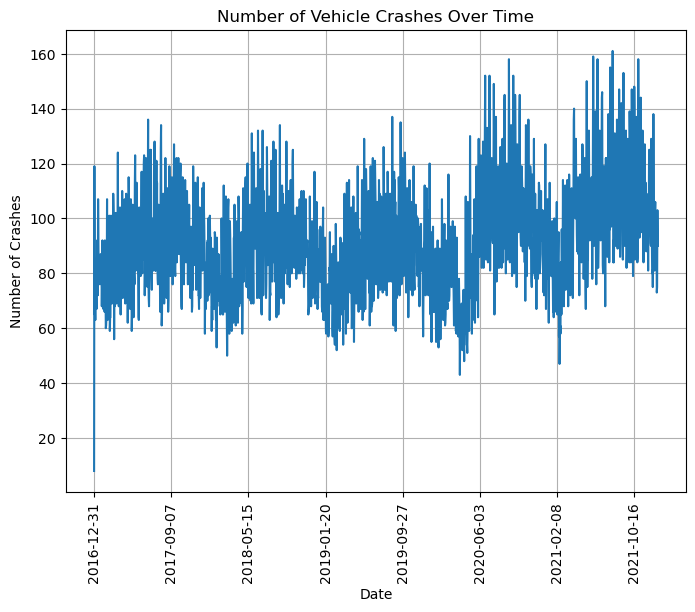

In [61]:
def drawPlot_1(df):
    crashes_per_day = df.groupby('CrashDate').size()
    plt.figure(figsize=(8, 6))
    crashes_per_day.plot(kind='line', linestyle='-' )
    plt.title('Number of Vehicle Crashes Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Crashes')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()

df = readLocalEnriched()
df = df.reset_index(drop = True)
print(df.columns)
drawPlot_1(df)

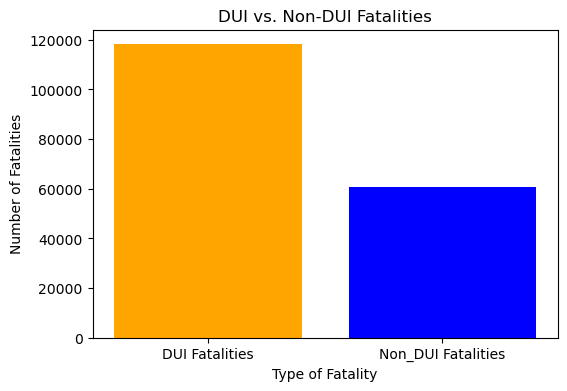

Index(['level_0', 'index', 'Unnamed: 0', 'CountyName', 'CrashDate', 'Fatals',
       'Peds', 'Persons', 'St_Case', 'State', 'StateName', 'TotalVehicles',
       'CarMakeList', 'isDUI', 'WEATHER', 'FATAL_COUNT'],
      dtype='object')


In [62]:
DUI_df = df[df['isDUI'] ==True]
non_DUI_df = df[df['isDUI']==False]
DUI_fatalities_count = DUI_df ['Fatals'].sum()
non_DUI_fatalities_count = non_DUI_df ['Fatals'].sum()

categories = ['DUI Fatalities', 'Non_DUI Fatalities']
fatalities_count = [DUI_fatalities_count, non_DUI_fatalities_count]

plt.figure(figsize=(6,4))
plt.bar(categories, fatalities_count, color=['orange','blue'])
plt.title('DUI vs. Non-DUI Fatalities')
plt.xlabel('Type of Fatality')
plt.ylabel('Number of Fatalities')
plt.show()

df = readLocalEnriched()
df = df.reset_index(drop = True)
print(df.columns)


<function matplotlib.pyplot.show(close=None, block=None)>

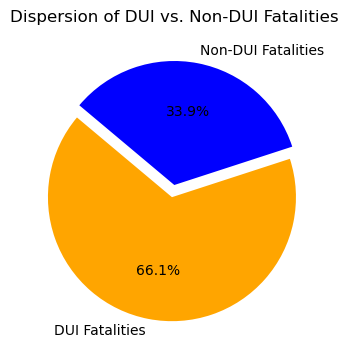

In [63]:
categories = ['DUI Fatalities','Non-DUI Fatalities']
fatalities_count = [DUI_fatalities_count, non_DUI_fatalities_count]

plt.figure(figsize = (4,6))
plt.pie(fatalities_count, labels=categories, colors=['orange','blue'], explode=(0.1,0), autopct='%1.1f%%',startangle=140)
plt.title('Dispersion of DUI vs. Non-DUI Fatalities')
plt.show
